In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [2]:
## Mout your google drive
from google.colab import drive
## mount location
drive.mount('/content/drive')

Mounted at /content/drive


## **LOADING A SAVED TFRECORD FILE**

In [3]:
## Globals
IMAGE_SHAPE = [32, 32, 3]
IMAGE_RESIZED_SHAPE = [32, 32]
SHARPNESS_FACTOR = 0.4
EPSILON = 1e-5
NUM_DEBUG_IMAGES = 3

In [4]:
## The path where the tf record file is
file_name = '/content/drive/My Drive/public_data/cifar_10/cifar_10_data_dataset_api.tfrecords'
## Load the raw tf record file from the file system
raw_image_dataset = tf.data.TFRecordDataset(file_name)
print(raw_image_dataset) ## gives no much information since the parsing of a tfrecord file is not yet implemented
## To parse a tfrecord file, one needs the structure of the record file (How the data is structured when they are saved)

<TFRecordDatasetV2 shapes: (), types: tf.string>


In [5]:
## Make the structure that would help us to parse the TFRecord file
## feature descriptor dict
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

In [6]:
## Now we make a function that an iterator can take as an higher oder function
def _parser_image_function(example_proto):
    ## Parse a single image feature structure
    ## serialized byte --> _parser_image_function(feature description) --> parsed image structure (see image_example function)
    return tf.io.parse_single_example(example_proto, image_feature_description)

In [7]:
## python map on an iterator example
def square_element(x):
  return x ** 2

a = np.arange(0, 10, 1)
print("Input Iterator {}".format(a))
b = list(map(lambda x: square_element(x), a))
print("Output Iterator {}".format(b))
## Note here the a havent changed. The mapping function produces a new list
## call the function by means of an iterator mapping. Please see the above mapping. Both works the same way
parsed_image_dataset = raw_image_dataset.map(_parser_image_function)

Input Iterator [0 1 2 3 4 5 6 7 8 9]
Output Iterator [0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


In [8]:
## Now we have access to the keys of the dataset data structure (keys are defined in the feature descreption dict).
## store images in a list (Only to debug (view and see the images))
'''
image_list = list()
for image_features in parsed_image_dataset:
    ## image byte string --> tf.io.decode_raw --> tf.uint8 image tensor
    image_uint = tf.io.decode_raw(image_features['image_raw'], out_type=tf.uint8)
    ## get the labels as well (No need to decode because they are stored as int64 values)
    image_label = image_features['label']
    ## append the decoded images to the list
    image_list.append(image_uint.numpy()) 
'''

def image_label(image_features):
  image_decoded = tf.io.decode_raw(image_features['image_raw'], out_type=tf.uint8)
  image_out = tf.reshape(image_decoded, IMAGE_SHAPE)
  image_label = image_features['label']
  
  return image_out, image_label

image_label_dataset = parsed_image_dataset.map(image_label)

In [9]:
## view some images
#for img, lbl in image_label_dataset.take(3):
#  plt.imshow(img)
#  plt.show()

In [10]:
## Switch the normalization method as you wish
norm_method = "z_score" # "min_max"
## define a transformer function
def z_stand_image(image):
  image = tf.cast(image, tf.float32)
  mean, variance = tf.nn.moments(image, axes=[0, 1, 2])
  return (image - mean) / tf.sqrt(variance + EPSILON)

def min_max_image(image):
  min = tf.reduce_min(image)
  max = tf.reduce_max(image)
  return (image - min) / (max - min)

def transform_image(image_features):
  ## decode the image
  image_decoded = tf.io.decode_raw(image_features['image_raw'], out_type=tf.uint8)
  image_out = tf.reshape(image_decoded, IMAGE_SHAPE)
  image_out = tf.image.random_flip_left_right(image_out)
  image_out = tf.image.random_brightness(image_out, SHARPNESS_FACTOR)
  ## normalize the image
  '''
  if norm_method == "z_score":
    image_out = z_stand_image(image_out)
  elif norm_method == "min_max":
    image_out = min_max_image(image_out)
  else:
    print("Unkown method")
  '''
  image_label = image_features['label']

  return image_out, image_label


In [11]:
transformed_dataset = parsed_image_dataset.map(transform_image)

In [12]:
#for trf_image in transformed_dataset.take(5):
#  plt.imshow(trf_image[0].numpy())
#  plt.show()
'''
image_list = list()
for img, lbl in transformed_dataset:
  #print(tf.reduce_min(img))
  #print(tf.nn.moments(img, 2))
  image_list.append(img.numpy())

print(np.min(np.array(image_list)))
print(np.max(np.array(image_list)))
'''

'\nimage_list = list()\nfor img, lbl in transformed_dataset:\n  #print(tf.reduce_min(img))\n  #print(tf.nn.moments(img, 2))\n  image_list.append(img.numpy())\n\nprint(np.min(np.array(image_list)))\nprint(np.max(np.array(image_list)))\n'

In [13]:
#image_from_back = image_list[40000]
#plt.imshow(image_from_back)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


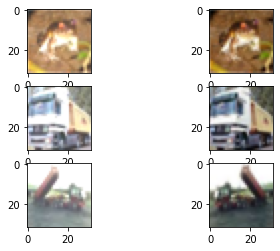

In [15]:
fig=plt.figure()
count = 1
for (img_t, lbl_t), (img, lbl) in zip(transformed_dataset.take(NUM_DEBUG_IMAGES), image_label_dataset.take(NUM_DEBUG_IMAGES)):
  fig.add_subplot(NUM_DEBUG_IMAGES, 2, count)
  print(type(img_t.numpy()))
  plt.imshow(img_t)
  fig.add_subplot(NUM_DEBUG_IMAGES, 2, count+1)
  plt.imshow(img)
  count += 2
#  print(tf.math.reduce_max(img))
#  print(tf.math.reduce_min(img))
#  print()